# Модель корректировок
В этом ноубуке мы построим модель корректировок с помощью реализованных классов и функций

In [2]:
%load_ext autoreload
%autoreload 2

## Загрузка и обработка данных

In [3]:
info =  {
    'offer_id': 'keep',
    'n_photos': 'keep',
    'source': 'keep',
    'house_guid': 'keep',
    'house_lat': 'keep',
    'house_lon': 'keep',
    'floor': 'keep',
    'rooms': 'keep',
    'renovation': 'delete',
    'repair_class_id': 'delete',
    'quality_class_id': 'delete',
    'quality': 'mean',
    'balconies': 0,
    'loggias': 0,
    'area_total': 'keep',
    'living_area': 'change',
    'kitchen_area': 'change',
    'built_year_fillna_own': 'delete',
    'built_year_fillna_sim_low': 'median',
    'entrance_count': 'mode',
    'elevators_count': 'mode',
    'floors_fillna_own': 'mode',
    'wall_material_fillna_own': 'delete',
    'wall_material_fillna_sim_low': 'mode',
    'ceiling_height_fillna_own': 'mode',
    'flat_class_mean': 'mean',
    'is_apartment_mean': 'mean',
    'region': 'keep',
    'amenities': 'keep',
    'infrastructure': 'keep',
    'commission': 'delete',
    'deposit': 'mean',
    'haggle': 'True',
    'communal_payments': 'delete',
    'price': 'keep',
}

In [15]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# мои файлы
from data_process import load_data, process_outliers, process_missing_values, format_features, split_data
from permutation_test import permutation_importance
from corrections_model import CorrectionsModel
from tune_model import optimize_catboost

In [5]:
# загрузим данные
data = load_data() 

# убираем выбросы
data = process_outliers(data)

# заполняем пропущенные значения
data = process_missing_values(data, info)

/Users/aksveronika/Desktop/Курсовая/data_process.py:18: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv('/Users/aksveronika/Desktop/Курсовая/analogs_2023-05-31_2023-06-30.csv')


In [6]:
columns_with_missing_values = data.columns[data.isnull().any()]

# У каких признаков есть пропуски и сколько их
print(data[columns_with_missing_values].isnull().sum())

Series([], dtype: float64)


In [7]:
train, val, test = split_data(data)

Размер train выборки: 7769926
Размер val выборки: 452150
Размер test выборки: 367390
Уникальных объектов в train: 39560
Уникальных объектов в val: 4945
Уникальных объектов в test: 4946


## Модель 

In [8]:
train_copy = train.drop(['a_actual_dt', 'b_valid_from', 'b_valid_to'], axis=1)
test_copy = test.drop(['a_actual_dt', 'b_valid_from', 'b_valid_to'], axis=1)
val_copy = val.drop(['a_actual_dt', 'b_valid_from', 'b_valid_to'], axis=1)

In [9]:
corr_model = CorrectionsModel()
f2 = corr_model.fit(train_copy, val_copy)

0:	learn: 0.6265151	test: 0.6552603	best: 0.6552603 (0)	total: 2.87s	remaining: 4m 44s
1:	learn: 0.6178009	test: 0.6474906	best: 0.6474906 (1)	total: 6.28s	remaining: 5m 7s
2:	learn: 0.6089112	test: 0.6390649	best: 0.6390649 (2)	total: 9.72s	remaining: 5m 14s
3:	learn: 0.6008446	test: 0.6317032	best: 0.6317032 (3)	total: 12.8s	remaining: 5m 7s
4:	learn: 0.5926892	test: 0.6240112	best: 0.6240112 (4)	total: 16.2s	remaining: 5m 7s
5:	learn: 0.5852630	test: 0.6171425	best: 0.6171425 (5)	total: 19.6s	remaining: 5m 7s
6:	learn: 0.5777498	test: 0.6102763	best: 0.6102763 (6)	total: 22.9s	remaining: 5m 3s
7:	learn: 0.5706372	test: 0.6037964	best: 0.6037964 (7)	total: 26.4s	remaining: 5m 3s
8:	learn: 0.5642904	test: 0.5978829	best: 0.5978829 (8)	total: 29.4s	remaining: 4m 57s
9:	learn: 0.5575290	test: 0.5911865	best: 0.5911865 (9)	total: 33s	remaining: 4m 57s
10:	learn: 0.5509387	test: 0.5849673	best: 0.5849673 (10)	total: 35.7s	remaining: 4m 48s
11:	learn: 0.5449839	test: 0.5793001	best: 0.5793

In [11]:
result = corr_model.predict(test_copy)
corr_model.calculate_metric(result)

22.1988658921796

In [31]:
mape_grid = []
for analog_num in range(6, 26, 2):
    corr_model2 = CorrectionsModel(analogs_num=analog_num)
    corr_model2.fit(train_copy, val_copy)
    result = corr_model2.predict(test_copy)
    mape_grid.append(corr_model2.calculate_metric(result))
mape_grid

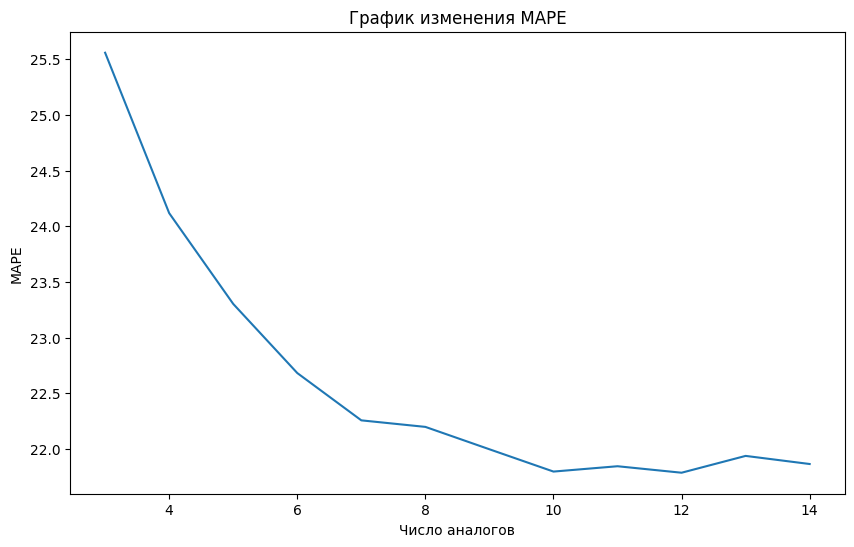

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(4, 20, 2), y=mape_grid)
plt.title('График изменения MAPE')
plt.xlabel('Число аналогов')
plt.ylabel('MAPE')
plt.show()

In [15]:
mape_grid

[25.558144940835454,
 24.117973076438528,
 23.302888134297724,
 22.682327099458398,
 22.25755993385406,
 22.1988658921796,
 21.99792935079102,
 21.797736516190618,
 21.845641879273316,
 21.787396590046953,
 21.938422741594547,
 21.865601789737042]

In [16]:
corr_model2 = CorrectionsModel(analogs_num=12)
f2 = corr_model2.fit(train_copy, val_copy)
result2 = corr_model2.predict(test_copy)
corr_model2.calculate_metric(result2)

0:	learn: 0.6265151	test: 0.6552603	best: 0.6552603 (0)	total: 4.17s	remaining: 6m 52s
1:	learn: 0.6178009	test: 0.6474906	best: 0.6474906 (1)	total: 7.28s	remaining: 5m 56s
2:	learn: 0.6089112	test: 0.6390649	best: 0.6390649 (2)	total: 10.2s	remaining: 5m 29s
3:	learn: 0.6008446	test: 0.6317032	best: 0.6317032 (3)	total: 12.8s	remaining: 5m 6s
4:	learn: 0.5926892	test: 0.6240112	best: 0.6240112 (4)	total: 15.5s	remaining: 4m 55s
5:	learn: 0.5852630	test: 0.6171425	best: 0.6171425 (5)	total: 18s	remaining: 4m 42s
6:	learn: 0.5777498	test: 0.6102763	best: 0.6102763 (6)	total: 20.6s	remaining: 4m 33s
7:	learn: 0.5706372	test: 0.6037964	best: 0.6037964 (7)	total: 23.6s	remaining: 4m 30s
8:	learn: 0.5642904	test: 0.5978829	best: 0.5978829 (8)	total: 26.1s	remaining: 4m 23s
9:	learn: 0.5575290	test: 0.5911865	best: 0.5911865 (9)	total: 28.8s	remaining: 4m 19s
10:	learn: 0.5509387	test: 0.5849673	best: 0.5849673 (10)	total: 31.2s	remaining: 4m 12s
11:	learn: 0.5449839	test: 0.5793001	best: 0

21.787396590046953

In [17]:
train_copy2 = process_outliers(train_copy, 
                            max_rooms=10,
                            max_ceiling_height_fillna_own=9
                            )

In [18]:
from corrections_model import CorrectionsModel # !!! в конце убрать

corr_model3 = CorrectionsModel(analogs_num=12)
f3 = corr_model3.fit(train_copy2, val_copy)
resul3 = corr_model3.predict(test_copy)
corr_model3.calculate_metric(resul3)

0:	learn: 0.6261066	test: 0.6550619	best: 0.6550619 (0)	total: 2.97s	remaining: 4m 54s
1:	learn: 0.6171590	test: 0.6470677	best: 0.6470677 (1)	total: 5.46s	remaining: 4m 27s
2:	learn: 0.6093867	test: 0.6399830	best: 0.6399830 (2)	total: 7.98s	remaining: 4m 17s
3:	learn: 0.6012260	test: 0.6324805	best: 0.6324805 (3)	total: 10.4s	remaining: 4m 9s
4:	learn: 0.5928427	test: 0.6243585	best: 0.6243585 (4)	total: 13.3s	remaining: 4m 11s
5:	learn: 0.5845212	test: 0.6164261	best: 0.6164261 (5)	total: 16.3s	remaining: 4m 14s
6:	learn: 0.5768952	test: 0.6094532	best: 0.6094532 (6)	total: 18.5s	remaining: 4m 6s
7:	learn: 0.5703147	test: 0.6034141	best: 0.6034141 (7)	total: 21s	remaining: 4m 1s
8:	learn: 0.5633924	test: 0.5969594	best: 0.5969594 (8)	total: 23.8s	remaining: 4m
9:	learn: 0.5568830	test: 0.5906438	best: 0.5906438 (9)	total: 26.4s	remaining: 3m 57s
10:	learn: 0.5504105	test: 0.5844278	best: 0.5844278 (10)	total: 28.7s	remaining: 3m 52s
11:	learn: 0.5441245	test: 0.5785146	best: 0.57851

21.691612925823186

In [20]:
params = {'random_seed': 42, 'iterations': 199, 'learning_rate': 0.017039392610847352, 'depth': 8, 'subsample': 0.42348990920071794, 'colsample_bylevel': 0.9332669216682239, 'min_data_in_leaf': 20, 'loss_function': 'MAE'}
corr_model4 = CorrectionsModel(analogs_num=12, params=params)
f4 = corr_model4.fit(train_copy2, val_copy)
result4 = corr_model4.predict(test_copy)
corr_model4.calculate_metric(result4)


0:	learn: 0.6297170	test: 0.6582408	best: 0.6582408 (0)	total: 1.58s	remaining: 5m 12s
1:	learn: 0.6243042	test: 0.6533474	best: 0.6533474 (1)	total: 2.81s	remaining: 4m 37s
2:	learn: 0.6186491	test: 0.6477759	best: 0.6477759 (2)	total: 3.96s	remaining: 4m 18s
3:	learn: 0.6133874	test: 0.6430086	best: 0.6430086 (3)	total: 5.21s	remaining: 4m 13s
4:	learn: 0.6083561	test: 0.6382817	best: 0.6382817 (4)	total: 6.32s	remaining: 4m 5s
5:	learn: 0.6035236	test: 0.6337275	best: 0.6337275 (5)	total: 7.4s	remaining: 3m 58s
6:	learn: 0.5981773	test: 0.6285899	best: 0.6285899 (6)	total: 8.7s	remaining: 3m 58s
7:	learn: 0.5935116	test: 0.6244039	best: 0.6244039 (7)	total: 9.78s	remaining: 3m 53s
8:	learn: 0.5883671	test: 0.6194767	best: 0.6194767 (8)	total: 11.4s	remaining: 4m
9:	learn: 0.5835132	test: 0.6149634	best: 0.6149634 (9)	total: 12.7s	remaining: 3m 59s
10:	learn: 0.5786313	test: 0.6103278	best: 0.6103278 (10)	total: 14s	remaining: 3m 58s
11:	learn: 0.5738363	test: 0.6057854	best: 0.60578

20.814658601993862

In [179]:
f4.head(50)

,Feature,Importance
24,a_area_total,22.233427
5,b_house_guid,17.407262
4,a_house_guid,15.890268
25,b_area_total,10.233162
26,a_living_area,4.345866
50,a_haggle,3.178329
12,a_rooms,2.878248
13,b_rooms,2.626872
27,b_living_area,2.532218
19,b_quality,2.387996


In [23]:
# Запускаем модель с параметрами, которые перебираем чуть ниже
params = {'random_seed': 42, 'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56, 'loss_function': 'MAE'}
corr_model4 = CorrectionsModel(analogs_num=12, params=params)
f4 = corr_model4.fit(train_copy2, val_copy)
result4 = corr_model4.predict(test_copy)
corr_model4.calculate_metric(result4)


0:	learn: 0.6004117	test: 0.6333800	best: 0.6333800 (0)	total: 3.08s	remaining: 12m 24s
1:	learn: 0.5694540	test: 0.6042829	best: 0.6042829 (1)	total: 6.71s	remaining: 13m 28s
2:	learn: 0.5418295	test: 0.5804198	best: 0.5804198 (2)	total: 8.85s	remaining: 11m 47s
3:	learn: 0.5183769	test: 0.5595194	best: 0.5595194 (3)	total: 11.5s	remaining: 11m 29s
4:	learn: 0.4961958	test: 0.5402230	best: 0.5402230 (4)	total: 13.9s	remaining: 10m 59s
5:	learn: 0.4766111	test: 0.5213100	best: 0.5213100 (5)	total: 16.4s	remaining: 10m 47s
6:	learn: 0.4580235	test: 0.5033785	best: 0.5033785 (6)	total: 19.5s	remaining: 10m 58s
7:	learn: 0.4427245	test: 0.4889272	best: 0.4889272 (7)	total: 21.9s	remaining: 10m 44s
8:	learn: 0.4279929	test: 0.4753424	best: 0.4753424 (8)	total: 24.7s	remaining: 10m 42s
9:	learn: 0.4160425	test: 0.4641655	best: 0.4641655 (9)	total: 27.9s	remaining: 10m 49s
10:	learn: 0.4043760	test: 0.4519840	best: 0.4519840 (10)	total: 30.5s	remaining: 10m 43s
11:	learn: 0.3943842	test: 0.4

18.59568063821465

In [19]:
from corrections_model import CorrectionsModel # !!! в конце убрать
from tune_model import optimize_catboost # !!! в конце убрать

best_trial = optimize_catboost(val_copy)
best_trial


[I 2024-05-13 19:19:30,706] A new study created in memory with name: no-name-735a4022-b074-4e9c-9468-22d68a56f75b


{'random_seed': 42, 'iterations': 226, 'learning_rate': 0.004541753043412277, 'depth': 8, 'subsample': 0.5401997001178135, 'colsample_bylevel': 0.5279375456607434, 'min_data_in_leaf': 17, 'loss_function': 'MAE'}
0:	learn: 0.6626693	test: 0.6592728	best: 0.6592728 (0)	total: 216ms	remaining: 48.6s
1:	learn: 0.6608177	test: 0.6573756	best: 0.6573756 (1)	total: 349ms	remaining: 39s
2:	learn: 0.6589530	test: 0.6554602	best: 0.6554602 (2)	total: 512ms	remaining: 38.1s
3:	learn: 0.6571758	test: 0.6536157	best: 0.6536157 (3)	total: 688ms	remaining: 38.2s
4:	learn: 0.6553950	test: 0.6517874	best: 0.6517874 (4)	total: 851ms	remaining: 37.6s
5:	learn: 0.6536140	test: 0.6499310	best: 0.6499310 (5)	total: 978ms	remaining: 35.8s
6:	learn: 0.6518731	test: 0.6481205	best: 0.6481205 (6)	total: 1.06s	remaining: 33.3s
7:	learn: 0.6501085	test: 0.6463031	best: 0.6463031 (7)	total: 1.17s	remaining: 32s
8:	learn: 0.6483218	test: 0.6444576	best: 0.6444576 (8)	total: 1.28s	remaining: 30.9s
9:	learn: 0.646535

[I 2024-05-13 19:20:00,501] Trial 0 finished with value: 16.484744813714062 and parameters: {'iterations': 226, 'learning_rate': 0.004541753043412277, 'depth': 8, 'subsample': 0.5401997001178135, 'colsample_bylevel': 0.5279375456607434, 'min_data_in_leaf': 17}. Best is trial 0 with value: 16.484744813714062.


{'random_seed': 42, 'iterations': 65, 'learning_rate': 0.022300149993353998, 'depth': 9, 'subsample': 0.5462100774812695, 'colsample_bylevel': 0.861072353302346, 'min_data_in_leaf': 31, 'loss_function': 'MAE'}
0:	learn: 0.6539265	test: 0.6580729	best: 0.6580729 (0)	total: 134ms	remaining: 8.61s
1:	learn: 0.6454291	test: 0.6494148	best: 0.6494148 (1)	total: 224ms	remaining: 7.07s
2:	learn: 0.6372278	test: 0.6410825	best: 0.6410825 (2)	total: 335ms	remaining: 6.92s
3:	learn: 0.6292603	test: 0.6329361	best: 0.6329361 (3)	total: 519ms	remaining: 7.91s
4:	learn: 0.6215999	test: 0.6251072	best: 0.6251072 (4)	total: 668ms	remaining: 8.02s
5:	learn: 0.6140661	test: 0.6173577	best: 0.6173577 (5)	total: 799ms	remaining: 7.85s
6:	learn: 0.6067160	test: 0.6097761	best: 0.6097761 (6)	total: 889ms	remaining: 7.36s
7:	learn: 0.5996847	test: 0.6025581	best: 0.6025581 (7)	total: 974ms	remaining: 6.94s
8:	learn: 0.5925873	test: 0.5952754	best: 0.5952754 (8)	total: 1.07s	remaining: 6.63s
9:	learn: 0.5859

[I 2024-05-13 19:20:08,836] Trial 1 finished with value: 14.902943477356281 and parameters: {'iterations': 65, 'learning_rate': 0.022300149993353998, 'depth': 9, 'subsample': 0.5462100774812695, 'colsample_bylevel': 0.861072353302346, 'min_data_in_leaf': 31}. Best is trial 1 with value: 14.902943477356281.


{'random_seed': 42, 'iterations': 359, 'learning_rate': 0.0010496751527638978, 'depth': 6, 'subsample': 0.8630304342840589, 'colsample_bylevel': 0.4425268762242589, 'min_data_in_leaf': 38, 'loss_function': 'MAE'}
0:	learn: 0.6629805	test: 0.6620823	best: 0.6620823 (0)	total: 180ms	remaining: 1m 4s
1:	learn: 0.6626249	test: 0.6617065	best: 0.6617065 (1)	total: 328ms	remaining: 58.5s
2:	learn: 0.6622268	test: 0.6612906	best: 0.6612906 (2)	total: 421ms	remaining: 50s
3:	learn: 0.6618198	test: 0.6608674	best: 0.6608674 (3)	total: 614ms	remaining: 54.5s
4:	learn: 0.6614221	test: 0.6604503	best: 0.6604503 (4)	total: 765ms	remaining: 54.2s
5:	learn: 0.6610254	test: 0.6600307	best: 0.6600307 (5)	total: 864ms	remaining: 50.8s
6:	learn: 0.6606376	test: 0.6596267	best: 0.6596267 (6)	total: 981ms	remaining: 49.4s
7:	learn: 0.6602571	test: 0.6592334	best: 0.6592334 (7)	total: 1.07s	remaining: 47.1s
8:	learn: 0.6598611	test: 0.6588193	best: 0.6588193 (8)	total: 1.2s	remaining: 46.5s
9:	learn: 0.6595

[I 2024-05-13 19:20:48,097] Trial 2 finished with value: 21.75737486796456 and parameters: {'iterations': 359, 'learning_rate': 0.0010496751527638978, 'depth': 6, 'subsample': 0.8630304342840589, 'colsample_bylevel': 0.4425268762242589, 'min_data_in_leaf': 38}. Best is trial 1 with value: 14.902943477356281.


{'random_seed': 42, 'iterations': 413, 'learning_rate': 0.03118586217863278, 'depth': 4, 'subsample': 0.08013129710511227, 'colsample_bylevel': 0.7258030613615073, 'min_data_in_leaf': 48, 'loss_function': 'MAE'}
0:	learn: 0.6520804	test: 0.6515363	best: 0.6515363 (0)	total: 104ms	remaining: 43s
1:	learn: 0.6424248	test: 0.6416555	best: 0.6416555 (1)	total: 169ms	remaining: 34.8s
2:	learn: 0.6338917	test: 0.6324494	best: 0.6324494 (2)	total: 263ms	remaining: 36s
3:	learn: 0.6245415	test: 0.6223136	best: 0.6223136 (3)	total: 327ms	remaining: 33.5s
4:	learn: 0.6162004	test: 0.6131256	best: 0.6131256 (4)	total: 400ms	remaining: 32.7s
5:	learn: 0.6071585	test: 0.6037680	best: 0.6037680 (5)	total: 464ms	remaining: 31.5s
6:	learn: 0.5989501	test: 0.5950653	best: 0.5950653 (6)	total: 506ms	remaining: 29.4s
7:	learn: 0.5902068	test: 0.5859584	best: 0.5859584 (7)	total: 552ms	remaining: 28s
8:	learn: 0.5832503	test: 0.5787348	best: 0.5787348 (8)	total: 604ms	remaining: 27.1s
9:	learn: 0.5760573	

[I 2024-05-13 19:21:18,073] Trial 3 finished with value: 14.545219961573569 and parameters: {'iterations': 413, 'learning_rate': 0.03118586217863278, 'depth': 4, 'subsample': 0.08013129710511227, 'colsample_bylevel': 0.7258030613615073, 'min_data_in_leaf': 48}. Best is trial 3 with value: 14.545219961573569.


{'random_seed': 42, 'iterations': 143, 'learning_rate': 0.019601670161372542, 'depth': 9, 'subsample': 0.37337718852835816, 'colsample_bylevel': 0.4544665501339752, 'min_data_in_leaf': 77, 'loss_function': 'MAE'}
0:	learn: 0.6565629	test: 0.6544704	best: 0.6544704 (0)	total: 101ms	remaining: 14.3s
1:	learn: 0.6496984	test: 0.6476280	best: 0.6476280 (1)	total: 173ms	remaining: 12.2s
2:	learn: 0.6425869	test: 0.6403870	best: 0.6403870 (2)	total: 249ms	remaining: 11.6s
3:	learn: 0.6352687	test: 0.6329440	best: 0.6329440 (3)	total: 313ms	remaining: 10.9s
4:	learn: 0.6286437	test: 0.6262292	best: 0.6262292 (4)	total: 385ms	remaining: 10.6s
5:	learn: 0.6222704	test: 0.6198054	best: 0.6198054 (5)	total: 446ms	remaining: 10.2s
6:	learn: 0.6157347	test: 0.6132504	best: 0.6132504 (6)	total: 529ms	remaining: 10.3s
7:	learn: 0.6094096	test: 0.6068233	best: 0.6068233 (7)	total: 595ms	remaining: 10s
8:	learn: 0.6031489	test: 0.6005216	best: 0.6005216 (8)	total: 661ms	remaining: 9.84s
9:	learn: 0.596

[I 2024-05-13 19:21:29,924] Trial 4 finished with value: 13.808525344018612 and parameters: {'iterations': 143, 'learning_rate': 0.019601670161372542, 'depth': 9, 'subsample': 0.37337718852835816, 'colsample_bylevel': 0.4544665501339752, 'min_data_in_leaf': 77}. Best is trial 4 with value: 13.808525344018612.


{'random_seed': 42, 'iterations': 456, 'learning_rate': 0.005836983981222111, 'depth': 6, 'subsample': 0.5725731035567385, 'colsample_bylevel': 0.734098530345404, 'min_data_in_leaf': 58, 'loss_function': 'MAE'}
0:	learn: 0.6623116	test: 0.6597072	best: 0.6597072 (0)	total: 184ms	remaining: 1m 23s
1:	learn: 0.6604226	test: 0.6576498	best: 0.6576498 (1)	total: 291ms	remaining: 1m 6s
2:	learn: 0.6582825	test: 0.6554241	best: 0.6554241 (2)	total: 428ms	remaining: 1m 4s
3:	learn: 0.6561051	test: 0.6531533	best: 0.6531533 (3)	total: 534ms	remaining: 1m
4:	learn: 0.6539092	test: 0.6508710	best: 0.6508710 (4)	total: 616ms	remaining: 55.6s
5:	learn: 0.6518486	test: 0.6486531	best: 0.6486531 (5)	total: 685ms	remaining: 51.3s
6:	learn: 0.6497156	test: 0.6463930	best: 0.6463930 (6)	total: 760ms	remaining: 48.8s
7:	learn: 0.6479811	test: 0.6445567	best: 0.6445567 (7)	total: 821ms	remaining: 46s
8:	learn: 0.6460716	test: 0.6423970	best: 0.6423970 (8)	total: 889ms	remaining: 44.2s
9:	learn: 0.6439965

[I 2024-05-13 19:22:18,015] Trial 5 finished with value: 16.12094046994686 and parameters: {'iterations': 456, 'learning_rate': 0.005836983981222111, 'depth': 6, 'subsample': 0.5725731035567385, 'colsample_bylevel': 0.734098530345404, 'min_data_in_leaf': 58}. Best is trial 4 with value: 13.808525344018612.


{'random_seed': 42, 'iterations': 401, 'learning_rate': 0.0017128705476035116, 'depth': 8, 'subsample': 0.7962030675967965, 'colsample_bylevel': 0.2156059777951152, 'min_data_in_leaf': 38, 'loss_function': 'MAE'}
0:	learn: 0.6624120	test: 0.6636824	best: 0.6636824 (0)	total: 181ms	remaining: 1m 12s
1:	learn: 0.6617463	test: 0.6629773	best: 0.6629773 (1)	total: 335ms	remaining: 1m 6s
2:	learn: 0.6611006	test: 0.6623056	best: 0.6623056 (2)	total: 460ms	remaining: 1m 1s
3:	learn: 0.6604164	test: 0.6615866	best: 0.6615866 (3)	total: 551ms	remaining: 54.7s
4:	learn: 0.6597971	test: 0.6609525	best: 0.6609525 (4)	total: 644ms	remaining: 51s
5:	learn: 0.6591133	test: 0.6602516	best: 0.6602516 (5)	total: 741ms	remaining: 48.8s
6:	learn: 0.6584613	test: 0.6595750	best: 0.6595750 (6)	total: 843ms	remaining: 47.5s
7:	learn: 0.6578068	test: 0.6588953	best: 0.6588953 (7)	total: 931ms	remaining: 45.7s
8:	learn: 0.6572118	test: 0.6582914	best: 0.6582914 (8)	total: 1.01s	remaining: 43.9s
9:	learn: 0.65

[I 2024-05-13 19:22:59,269] Trial 6 finished with value: 17.54272349598295 and parameters: {'iterations': 401, 'learning_rate': 0.0017128705476035116, 'depth': 8, 'subsample': 0.7962030675967965, 'colsample_bylevel': 0.2156059777951152, 'min_data_in_leaf': 38}. Best is trial 4 with value: 13.808525344018612.


{'random_seed': 42, 'iterations': 441, 'learning_rate': 0.01402170481177719, 'depth': 3, 'subsample': 0.994609613475293, 'colsample_bylevel': 0.750748223263882, 'min_data_in_leaf': 45, 'loss_function': 'MAE'}
0:	learn: 0.6600661	test: 0.6600902	best: 0.6600902 (0)	total: 124ms	remaining: 54.7s
1:	learn: 0.6561920	test: 0.6561330	best: 0.6561330 (1)	total: 222ms	remaining: 48.8s
2:	learn: 0.6524867	test: 0.6523632	best: 0.6523632 (2)	total: 296ms	remaining: 43.2s
3:	learn: 0.6486067	test: 0.6483704	best: 0.6483704 (3)	total: 372ms	remaining: 40.7s
4:	learn: 0.6453631	test: 0.6449072	best: 0.6449072 (4)	total: 481ms	remaining: 42s
5:	learn: 0.6421062	test: 0.6413909	best: 0.6413909 (5)	total: 570ms	remaining: 41.3s
6:	learn: 0.6389280	test: 0.6379259	best: 0.6379259 (6)	total: 638ms	remaining: 39.6s
7:	learn: 0.6358271	test: 0.6345454	best: 0.6345454 (7)	total: 696ms	remaining: 37.7s
8:	learn: 0.6326511	test: 0.6311011	best: 0.6311011 (8)	total: 756ms	remaining: 36.3s
9:	learn: 0.6293126

[I 2024-05-13 19:23:33,940] Trial 7 finished with value: 17.304887673917495 and parameters: {'iterations': 441, 'learning_rate': 0.01402170481177719, 'depth': 3, 'subsample': 0.994609613475293, 'colsample_bylevel': 0.750748223263882, 'min_data_in_leaf': 45}. Best is trial 4 with value: 13.808525344018612.


{'random_seed': 42, 'iterations': 426, 'learning_rate': 0.001364225839494502, 'depth': 7, 'subsample': 0.6595243456198165, 'colsample_bylevel': 0.7290307323568506, 'min_data_in_leaf': 87, 'loss_function': 'MAE'}
0:	learn: 0.6627102	test: 0.6608471	best: 0.6608471 (0)	total: 181ms	remaining: 1m 16s
1:	learn: 0.6621620	test: 0.6602790	best: 0.6602790 (1)	total: 319ms	remaining: 1m 7s
2:	learn: 0.6616216	test: 0.6597227	best: 0.6597227 (2)	total: 427ms	remaining: 1m
3:	learn: 0.6610846	test: 0.6591497	best: 0.6591497 (3)	total: 536ms	remaining: 56.5s
4:	learn: 0.6605474	test: 0.6585940	best: 0.6585940 (4)	total: 618ms	remaining: 52s
5:	learn: 0.6599943	test: 0.6580117	best: 0.6580117 (5)	total: 707ms	remaining: 49.5s
6:	learn: 0.6594681	test: 0.6574614	best: 0.6574614 (6)	total: 803ms	remaining: 48.1s
7:	learn: 0.6589271	test: 0.6568945	best: 0.6568945 (7)	total: 935ms	remaining: 48.9s
8:	learn: 0.6583821	test: 0.6563333	best: 0.6563333 (8)	total: 1.03s	remaining: 48s
9:	learn: 0.6578396	

[I 2024-05-13 19:24:21,952] Trial 8 finished with value: 19.013797532811434 and parameters: {'iterations': 426, 'learning_rate': 0.001364225839494502, 'depth': 7, 'subsample': 0.6595243456198165, 'colsample_bylevel': 0.7290307323568506, 'min_data_in_leaf': 87}. Best is trial 4 with value: 13.808525344018612.


{'random_seed': 42, 'iterations': 432, 'learning_rate': 0.011528832524943895, 'depth': 1, 'subsample': 0.9530501080425371, 'colsample_bylevel': 0.7931573219374242, 'min_data_in_leaf': 47, 'loss_function': 'MAE'}
0:	learn: 0.6617413	test: 0.6663748	best: 0.6663748 (0)	total: 79.3ms	remaining: 34.2s
1:	learn: 0.6610579	test: 0.6656905	best: 0.6656905 (1)	total: 139ms	remaining: 29.9s
2:	learn: 0.6595689	test: 0.6641236	best: 0.6641236 (2)	total: 201ms	remaining: 28.8s
3:	learn: 0.6580644	test: 0.6625380	best: 0.6625380 (3)	total: 250ms	remaining: 26.8s
4:	learn: 0.6566497	test: 0.6610404	best: 0.6610404 (4)	total: 295ms	remaining: 25.1s
5:	learn: 0.6558763	test: 0.6602648	best: 0.6602648 (5)	total: 338ms	remaining: 24s
6:	learn: 0.6544968	test: 0.6588033	best: 0.6588033 (6)	total: 390ms	remaining: 23.7s
7:	learn: 0.6537363	test: 0.6580404	best: 0.6580404 (7)	total: 433ms	remaining: 23s
8:	learn: 0.6523640	test: 0.6565874	best: 0.6565874 (8)	total: 479ms	remaining: 22.5s
9:	learn: 0.65099

[I 2024-05-13 19:24:43,876] Trial 9 finished with value: 19.765205707860982 and parameters: {'iterations': 432, 'learning_rate': 0.011528832524943895, 'depth': 1, 'subsample': 0.9530501080425371, 'colsample_bylevel': 0.7931573219374242, 'min_data_in_leaf': 47}. Best is trial 4 with value: 13.808525344018612.


{'random_seed': 42, 'iterations': 130, 'learning_rate': 0.08323038372174171, 'depth': 10, 'subsample': 0.15718795772350103, 'colsample_bylevel': 0.07341738019012961, 'min_data_in_leaf': 100, 'loss_function': 'MAE'}
0:	learn: 0.6355650	test: 0.6307967	best: 0.6307967 (0)	total: 95.3ms	remaining: 12.3s
1:	learn: 0.6099704	test: 0.6054035	best: 0.6054035 (1)	total: 161ms	remaining: 10.3s
2:	learn: 0.5856588	test: 0.5805070	best: 0.5805070 (2)	total: 209ms	remaining: 8.83s
3:	learn: 0.5737770	test: 0.5687089	best: 0.5687089 (3)	total: 245ms	remaining: 7.72s
4:	learn: 0.5541472	test: 0.5491759	best: 0.5491759 (4)	total: 304ms	remaining: 7.6s
5:	learn: 0.5380416	test: 0.5332403	best: 0.5332403 (5)	total: 364ms	remaining: 7.51s
6:	learn: 0.5289868	test: 0.5242160	best: 0.5242160 (6)	total: 415ms	remaining: 7.29s
7:	learn: 0.5111930	test: 0.5061620	best: 0.5061620 (7)	total: 468ms	remaining: 7.13s
8:	learn: 0.4957128	test: 0.4907524	best: 0.4907524 (8)	total: 524ms	remaining: 7.04s
9:	learn: 0

[I 2024-05-13 19:24:53,531] Trial 10 finished with value: 12.336926843079492 and parameters: {'iterations': 130, 'learning_rate': 0.08323038372174171, 'depth': 10, 'subsample': 0.15718795772350103, 'colsample_bylevel': 0.07341738019012961, 'min_data_in_leaf': 100}. Best is trial 10 with value: 12.336926843079492.


{'random_seed': 42, 'iterations': 133, 'learning_rate': 0.08678504321025608, 'depth': 10, 'subsample': 0.2453241035354429, 'colsample_bylevel': 0.07877474511178136, 'min_data_in_leaf': 99, 'loss_function': 'MAE'}
0:	learn: 0.6344504	test: 0.6333537	best: 0.6333537 (0)	total: 84ms	remaining: 11.1s
1:	learn: 0.6140557	test: 0.6129796	best: 0.6129796 (1)	total: 160ms	remaining: 10.5s
2:	learn: 0.5873849	test: 0.5857784	best: 0.5857784 (2)	total: 210ms	remaining: 9.12s
3:	learn: 0.5630161	test: 0.5608740	best: 0.5608740 (3)	total: 276ms	remaining: 8.89s
4:	learn: 0.5427720	test: 0.5406270	best: 0.5406270 (4)	total: 341ms	remaining: 8.73s
5:	learn: 0.5238260	test: 0.5213135	best: 0.5213135 (5)	total: 395ms	remaining: 8.36s
6:	learn: 0.5084435	test: 0.5055488	best: 0.5055488 (6)	total: 437ms	remaining: 7.86s
7:	learn: 0.4934463	test: 0.4903722	best: 0.4903722 (7)	total: 493ms	remaining: 7.71s
8:	learn: 0.4803781	test: 0.4765834	best: 0.4765834 (8)	total: 542ms	remaining: 7.47s
9:	learn: 0.46

[I 2024-05-13 19:25:03,456] Trial 11 finished with value: 13.28845707863073 and parameters: {'iterations': 133, 'learning_rate': 0.08678504321025608, 'depth': 10, 'subsample': 0.2453241035354429, 'colsample_bylevel': 0.07877474511178136, 'min_data_in_leaf': 99}. Best is trial 10 with value: 12.336926843079492.


{'random_seed': 42, 'iterations': 191, 'learning_rate': 0.09372198808933631, 'depth': 10, 'subsample': 0.18582435200025216, 'colsample_bylevel': 0.055829309220458, 'min_data_in_leaf': 99, 'loss_function': 'MAE'}
0:	learn: 0.6384985	test: 0.6365177	best: 0.6365177 (0)	total: 85.2ms	remaining: 16.2s
1:	learn: 0.6090135	test: 0.6067677	best: 0.6067677 (1)	total: 154ms	remaining: 14.5s
2:	learn: 0.5849568	test: 0.5821875	best: 0.5821875 (2)	total: 211ms	remaining: 13.2s
3:	learn: 0.5744204	test: 0.5708560	best: 0.5708560 (3)	total: 261ms	remaining: 12.2s
4:	learn: 0.5560151	test: 0.5525182	best: 0.5525182 (4)	total: 322ms	remaining: 12s
5:	learn: 0.5394799	test: 0.5359015	best: 0.5359015 (5)	total: 374ms	remaining: 11.5s
6:	learn: 0.5166486	test: 0.5118822	best: 0.5118822 (6)	total: 429ms	remaining: 11.3s
7:	learn: 0.4972590	test: 0.4923315	best: 0.4923315 (7)	total: 479ms	remaining: 10.9s
8:	learn: 0.4857684	test: 0.4809281	best: 0.4809281 (8)	total: 513ms	remaining: 10.4s
9:	learn: 0.471

[I 2024-05-13 19:25:15,825] Trial 12 finished with value: 11.97649035831799 and parameters: {'iterations': 191, 'learning_rate': 0.09372198808933631, 'depth': 10, 'subsample': 0.18582435200025216, 'colsample_bylevel': 0.055829309220458, 'min_data_in_leaf': 99}. Best is trial 12 with value: 11.97649035831799.


{'random_seed': 42, 'iterations': 256, 'learning_rate': 0.09716975127548012, 'depth': 10, 'subsample': 0.05372268925121357, 'colsample_bylevel': 0.0527561736010546, 'min_data_in_leaf': 71, 'loss_function': 'MAE'}
0:	learn: 0.6280334	test: 0.6269009	best: 0.6269009 (0)	total: 90.6ms	remaining: 23.1s
1:	learn: 0.6013212	test: 0.6001816	best: 0.6001816 (1)	total: 149ms	remaining: 18.9s
2:	learn: 0.5731031	test: 0.5715505	best: 0.5715505 (2)	total: 222ms	remaining: 18.8s
3:	learn: 0.5500378	test: 0.5479573	best: 0.5479573 (3)	total: 324ms	remaining: 20.4s
4:	learn: 0.5297172	test: 0.5272807	best: 0.5272807 (4)	total: 391ms	remaining: 19.6s
5:	learn: 0.5120228	test: 0.5087186	best: 0.5087186 (5)	total: 454ms	remaining: 18.9s
6:	learn: 0.4946392	test: 0.4909687	best: 0.4909687 (6)	total: 502ms	remaining: 17.8s
7:	learn: 0.4842036	test: 0.4806004	best: 0.4806004 (7)	total: 561ms	remaining: 17.4s
8:	learn: 0.4765009	test: 0.4726562	best: 0.4726562 (8)	total: 633ms	remaining: 17.4s
9:	learn: 0.

[I 2024-05-13 19:25:35,479] Trial 13 finished with value: 11.386327486131835 and parameters: {'iterations': 256, 'learning_rate': 0.09716975127548012, 'depth': 10, 'subsample': 0.05372268925121357, 'colsample_bylevel': 0.0527561736010546, 'min_data_in_leaf': 71}. Best is trial 13 with value: 11.386327486131835.


{'random_seed': 42, 'iterations': 265, 'learning_rate': 0.046495989075899996, 'depth': 10, 'subsample': 0.31459149512421525, 'colsample_bylevel': 0.2540048192317925, 'min_data_in_leaf': 68, 'loss_function': 'MAE'}
0:	learn: 0.6450980	test: 0.6431256	best: 0.6431256 (0)	total: 172ms	remaining: 45.3s
1:	learn: 0.6273984	test: 0.6244865	best: 0.6244865 (1)	total: 277ms	remaining: 36.5s
2:	learn: 0.6096547	test: 0.6061655	best: 0.6061655 (2)	total: 422ms	remaining: 36.9s
3:	learn: 0.5936374	test: 0.5896722	best: 0.5896722 (3)	total: 535ms	remaining: 34.9s
4:	learn: 0.5778800	test: 0.5723768	best: 0.5723768 (4)	total: 657ms	remaining: 34.1s
5:	learn: 0.5629276	test: 0.5566829	best: 0.5566829 (5)	total: 750ms	remaining: 32.4s
6:	learn: 0.5491376	test: 0.5422019	best: 0.5422019 (6)	total: 831ms	remaining: 30.6s
7:	learn: 0.5368926	test: 0.5296225	best: 0.5296225 (7)	total: 900ms	remaining: 28.9s
8:	learn: 0.5245346	test: 0.5166236	best: 0.5166236 (8)	total: 1.02s	remaining: 29s
9:	learn: 0.51

[I 2024-05-13 19:26:07,452] Trial 14 finished with value: 11.34247001536877 and parameters: {'iterations': 265, 'learning_rate': 0.046495989075899996, 'depth': 10, 'subsample': 0.31459149512421525, 'colsample_bylevel': 0.2540048192317925, 'min_data_in_leaf': 68}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 306, 'learning_rate': 0.04813798051336126, 'depth': 4, 'subsample': 0.37906763174660774, 'colsample_bylevel': 0.2583417553655425, 'min_data_in_leaf': 67, 'loss_function': 'MAE'}
0:	learn: 0.6473727	test: 0.6496617	best: 0.6496617 (0)	total: 101ms	remaining: 30.7s
1:	learn: 0.6342149	test: 0.6361349	best: 0.6361349 (1)	total: 193ms	remaining: 29.4s
2:	learn: 0.6236388	test: 0.6255506	best: 0.6255506 (2)	total: 251ms	remaining: 25.3s
3:	learn: 0.6118752	test: 0.6134376	best: 0.6134376 (3)	total: 299ms	remaining: 22.6s
4:	learn: 0.6001447	test: 0.6013336	best: 0.6013336 (4)	total: 345ms	remaining: 20.8s
5:	learn: 0.5929985	test: 0.5941694	best: 0.5941694 (5)	total: 384ms	remaining: 19.2s
6:	learn: 0.5834038	test: 0.5845669	best: 0.5845669 (6)	total: 437ms	remaining: 18.6s
7:	learn: 0.5726379	test: 0.5732328	best: 0.5732328 (7)	total: 483ms	remaining: 18s
8:	learn: 0.5641762	test: 0.5647824	best: 0.5647824 (8)	total: 528ms	remaining: 17.4s
9:	learn: 0.5534

[I 2024-05-13 19:26:26,810] Trial 15 finished with value: 14.44030800383824 and parameters: {'iterations': 306, 'learning_rate': 0.04813798051336126, 'depth': 4, 'subsample': 0.37906763174660774, 'colsample_bylevel': 0.2583417553655425, 'min_data_in_leaf': 67}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 270, 'learning_rate': 0.03774592304268339, 'depth': 8, 'subsample': 0.33604623617672136, 'colsample_bylevel': 0.26915947405945806, 'min_data_in_leaf': 65, 'loss_function': 'MAE'}
0:	learn: 0.6477724	test: 0.6478599	best: 0.6478599 (0)	total: 154ms	remaining: 41.5s
1:	learn: 0.6337708	test: 0.6330258	best: 0.6330258 (1)	total: 318ms	remaining: 42.6s
2:	learn: 0.6202809	test: 0.6190904	best: 0.6190904 (2)	total: 424ms	remaining: 37.7s
3:	learn: 0.6074257	test: 0.6057976	best: 0.6057976 (3)	total: 488ms	remaining: 32.5s
4:	learn: 0.5953300	test: 0.5935197	best: 0.5935197 (4)	total: 560ms	remaining: 29.7s
5:	learn: 0.5832927	test: 0.5810495	best: 0.5810495 (5)	total: 630ms	remaining: 27.7s
6:	learn: 0.5710255	test: 0.5680379	best: 0.5680379 (6)	total: 733ms	remaining: 27.6s
7:	learn: 0.5601726	test: 0.5568551	best: 0.5568551 (7)	total: 812ms	remaining: 26.6s
8:	learn: 0.5497732	test: 0.5459059	best: 0.5459059 (8)	total: 879ms	remaining: 25.5s
9:	learn: 0.5

[I 2024-05-13 19:26:53,777] Trial 16 finished with value: 13.755279956491014 and parameters: {'iterations': 270, 'learning_rate': 0.03774592304268339, 'depth': 8, 'subsample': 0.33604623617672136, 'colsample_bylevel': 0.26915947405945806, 'min_data_in_leaf': 65}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 311, 'learning_rate': 0.05294539847384922, 'depth': 9, 'subsample': 0.08653170699126816, 'colsample_bylevel': 0.18820784812659225, 'min_data_in_leaf': 79, 'loss_function': 'MAE'}
0:	learn: 0.6453334	test: 0.6467154	best: 0.6467154 (0)	total: 145ms	remaining: 44.8s
1:	learn: 0.6265395	test: 0.6276016	best: 0.6276016 (1)	total: 245ms	remaining: 37.8s
2:	learn: 0.6066701	test: 0.6067379	best: 0.6067379 (2)	total: 330ms	remaining: 33.8s
3:	learn: 0.5888001	test: 0.5876097	best: 0.5876097 (3)	total: 418ms	remaining: 32.1s
4:	learn: 0.5716644	test: 0.5700390	best: 0.5700390 (4)	total: 508ms	remaining: 31.1s
5:	learn: 0.5569489	test: 0.5549243	best: 0.5549243 (5)	total: 562ms	remaining: 28.6s
6:	learn: 0.5432985	test: 0.5407655	best: 0.5407655 (6)	total: 630ms	remaining: 27.3s
7:	learn: 0.5293961	test: 0.5264651	best: 0.5264651 (7)	total: 684ms	remaining: 25.9s
8:	learn: 0.5152209	test: 0.5116839	best: 0.5116839 (8)	total: 771ms	remaining: 25.9s
9:	learn: 0.5

[I 2024-05-13 19:27:24,050] Trial 17 finished with value: 11.849743791719511 and parameters: {'iterations': 311, 'learning_rate': 0.05294539847384922, 'depth': 9, 'subsample': 0.08653170699126816, 'colsample_bylevel': 0.18820784812659225, 'min_data_in_leaf': 79}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 229, 'learning_rate': 0.006900105535608234, 'depth': 7, 'subsample': 0.2965344509407747, 'colsample_bylevel': 0.3583973153803216, 'min_data_in_leaf': 1, 'loss_function': 'MAE'}
0:	learn: 0.6613771	test: 0.6611355	best: 0.6611355 (0)	total: 135ms	remaining: 30.9s
1:	learn: 0.6588355	test: 0.6585102	best: 0.6585102 (1)	total: 253ms	remaining: 28.7s
2:	learn: 0.6562068	test: 0.6557370	best: 0.6557370 (2)	total: 373ms	remaining: 28.1s
3:	learn: 0.6535719	test: 0.6530162	best: 0.6530162 (3)	total: 502ms	remaining: 28.3s
4:	learn: 0.6510213	test: 0.6503827	best: 0.6503827 (4)	total: 669ms	remaining: 30s
5:	learn: 0.6483258	test: 0.6475943	best: 0.6475943 (5)	total: 767ms	remaining: 28.5s
6:	learn: 0.6457794	test: 0.6449170	best: 0.6449170 (6)	total: 896ms	remaining: 28.4s
7:	learn: 0.6431810	test: 0.6422105	best: 0.6422105 (7)	total: 1.03s	remaining: 28.4s
8:	learn: 0.6409227	test: 0.6399208	best: 0.6399208 (8)	total: 1.16s	remaining: 28.3s
9:	learn: 0.63839

[I 2024-05-13 19:27:46,268] Trial 18 finished with value: 15.964628394891744 and parameters: {'iterations': 229, 'learning_rate': 0.006900105535608234, 'depth': 7, 'subsample': 0.2965344509407747, 'colsample_bylevel': 0.3583973153803216, 'min_data_in_leaf': 1}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 346, 'learning_rate': 0.002979775989553031, 'depth': 1, 'subsample': 0.44460659185450613, 'colsample_bylevel': 0.5663323437097438, 'min_data_in_leaf': 61, 'loss_function': 'MAE'}
0:	learn: 0.6630248	test: 0.6655328	best: 0.6655328 (0)	total: 76.1ms	remaining: 26.3s
1:	learn: 0.6626465	test: 0.6651346	best: 0.6651346 (1)	total: 141ms	remaining: 24.2s
2:	learn: 0.6624492	test: 0.6649370	best: 0.6649370 (2)	total: 195ms	remaining: 22.3s
3:	learn: 0.6620736	test: 0.6645417	best: 0.6645417 (3)	total: 242ms	remaining: 20.7s
4:	learn: 0.6618669	test: 0.6643353	best: 0.6643353 (4)	total: 281ms	remaining: 19.1s
5:	learn: 0.6614930	test: 0.6639417	best: 0.6639417 (5)	total: 327ms	remaining: 18.5s
6:	learn: 0.6613153	test: 0.6637637	best: 0.6637637 (6)	total: 374ms	remaining: 18.1s
7:	learn: 0.6609432	test: 0.6633718	best: 0.6633718 (7)	total: 420ms	remaining: 17.7s
8:	learn: 0.6605639	test: 0.6629721	best: 0.6629721 (8)	total: 457ms	remaining: 17.1s
9:	learn: 0.

[I 2024-05-13 19:28:02,021] Trial 19 finished with value: 22.6834159528265 and parameters: {'iterations': 346, 'learning_rate': 0.002979775989553031, 'depth': 1, 'subsample': 0.44460659185450613, 'colsample_bylevel': 0.5663323437097438, 'min_data_in_leaf': 61}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 256, 'learning_rate': 0.061815624324319564, 'depth': 5, 'subsample': 0.21152146299551483, 'colsample_bylevel': 0.15389956519875161, 'min_data_in_leaf': 78, 'loss_function': 'MAE'}
0:	learn: 0.6450602	test: 0.6458705	best: 0.6458705 (0)	total: 95.2ms	remaining: 24.3s
1:	learn: 0.6303014	test: 0.6310417	best: 0.6310417 (1)	total: 153ms	remaining: 19.4s
2:	learn: 0.6137898	test: 0.6145187	best: 0.6145187 (2)	total: 208ms	remaining: 17.5s
3:	learn: 0.6010704	test: 0.6017851	best: 0.6017851 (3)	total: 268ms	remaining: 16.9s
4:	learn: 0.5880467	test: 0.5887089	best: 0.5887089 (4)	total: 324ms	remaining: 16.2s
5:	learn: 0.5719483	test: 0.5719601	best: 0.5719601 (5)	total: 422ms	remaining: 17.6s
6:	learn: 0.5593023	test: 0.5587354	best: 0.5587354 (6)	total: 537ms	remaining: 19.1s
7:	learn: 0.5443587	test: 0.5428650	best: 0.5428650 (7)	total: 634ms	remaining: 19.6s
8:	learn: 0.5320216	test: 0.5299913	best: 0.5299913 (8)	total: 686ms	remaining: 18.8s
9:	learn: 0

[I 2024-05-13 19:28:22,904] Trial 20 finished with value: 14.169638695120703 and parameters: {'iterations': 256, 'learning_rate': 0.061815624324319564, 'depth': 5, 'subsample': 0.21152146299551483, 'colsample_bylevel': 0.15389956519875161, 'min_data_in_leaf': 78}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 329, 'learning_rate': 0.053871873875047986, 'depth': 9, 'subsample': 0.05085693551849219, 'colsample_bylevel': 0.1723059404900532, 'min_data_in_leaf': 78, 'loss_function': 'MAE'}
0:	learn: 0.6455554	test: 0.6432692	best: 0.6432692 (0)	total: 125ms	remaining: 41s
1:	learn: 0.6275717	test: 0.6253415	best: 0.6253415 (1)	total: 224ms	remaining: 36.6s
2:	learn: 0.6107489	test: 0.6085050	best: 0.6085050 (2)	total: 309ms	remaining: 33.6s
3:	learn: 0.5940739	test: 0.5915854	best: 0.5915854 (3)	total: 445ms	remaining: 36.2s
4:	learn: 0.5796617	test: 0.5771495	best: 0.5771495 (4)	total: 639ms	remaining: 41.4s
5:	learn: 0.5634292	test: 0.5603973	best: 0.5603973 (5)	total: 765ms	remaining: 41.2s
6:	learn: 0.5486887	test: 0.5454311	best: 0.5454311 (6)	total: 856ms	remaining: 39.4s
7:	learn: 0.5343639	test: 0.5302568	best: 0.5302568 (7)	total: 962ms	remaining: 38.6s
8:	learn: 0.5227758	test: 0.5184896	best: 0.5184896 (8)	total: 1.08s	remaining: 38.3s
9:	learn: 0.508

[I 2024-05-13 19:28:55,010] Trial 21 finished with value: 12.109137256601914 and parameters: {'iterations': 329, 'learning_rate': 0.053871873875047986, 'depth': 9, 'subsample': 0.05085693551849219, 'colsample_bylevel': 0.1723059404900532, 'min_data_in_leaf': 78}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 305, 'learning_rate': 0.030427933380366076, 'depth': 10, 'subsample': 0.11994487642518153, 'colsample_bylevel': 0.3326106087745215, 'min_data_in_leaf': 87, 'loss_function': 'MAE'}
0:	learn: 0.6506868	test: 0.6515116	best: 0.6515116 (0)	total: 291ms	remaining: 1m 28s
1:	learn: 0.6382421	test: 0.6386247	best: 0.6386247 (1)	total: 442ms	remaining: 1m 6s
2:	learn: 0.6262031	test: 0.6260777	best: 0.6260777 (2)	total: 664ms	remaining: 1m 6s
3:	learn: 0.6146932	test: 0.6140593	best: 0.6140593 (3)	total: 755ms	remaining: 56.8s
4:	learn: 0.6032759	test: 0.6021201	best: 0.6021201 (4)	total: 850ms	remaining: 51s
5:	learn: 0.5930340	test: 0.5913955	best: 0.5913955 (5)	total: 963ms	remaining: 48s
6:	learn: 0.5826187	test: 0.5803020	best: 0.5803020 (6)	total: 1.04s	remaining: 44.4s
7:	learn: 0.5723656	test: 0.5696196	best: 0.5696196 (7)	total: 1.19s	remaining: 44.2s
8:	learn: 0.5622567	test: 0.5593423	best: 0.5593423 (8)	total: 1.3s	remaining: 42.8s
9:	learn: 0.5528

[I 2024-05-13 19:29:33,389] Trial 22 finished with value: 12.010802848329401 and parameters: {'iterations': 305, 'learning_rate': 0.030427933380366076, 'depth': 10, 'subsample': 0.11994487642518153, 'colsample_bylevel': 0.3326106087745215, 'min_data_in_leaf': 87}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 190, 'learning_rate': 0.060301470053812214, 'depth': 9, 'subsample': 0.2683858173674447, 'colsample_bylevel': 0.13861003603893807, 'min_data_in_leaf': 72, 'loss_function': 'MAE'}
0:	learn: 0.6396711	test: 0.6397621	best: 0.6397621 (0)	total: 62ms	remaining: 11.7s
1:	learn: 0.6179118	test: 0.6171071	best: 0.6171071 (1)	total: 114ms	remaining: 10.7s
2:	learn: 0.6000313	test: 0.5989639	best: 0.5989639 (2)	total: 165ms	remaining: 10.3s
3:	learn: 0.5815803	test: 0.5801729	best: 0.5801729 (3)	total: 212ms	remaining: 9.86s
4:	learn: 0.5625763	test: 0.5605387	best: 0.5605387 (4)	total: 254ms	remaining: 9.4s
5:	learn: 0.5464654	test: 0.5438006	best: 0.5438006 (5)	total: 298ms	remaining: 9.14s
6:	learn: 0.5349233	test: 0.5322490	best: 0.5322490 (6)	total: 343ms	remaining: 8.97s
7:	learn: 0.5216235	test: 0.5186914	best: 0.5186914 (7)	total: 384ms	remaining: 8.74s
8:	learn: 0.5072016	test: 0.5038211	best: 0.5038211 (8)	total: 425ms	remaining: 8.55s
9:	learn: 0.495

[I 2024-05-13 19:29:46,048] Trial 23 finished with value: 11.920719923068447 and parameters: {'iterations': 190, 'learning_rate': 0.060301470053812214, 'depth': 9, 'subsample': 0.2683858173674447, 'colsample_bylevel': 0.13861003603893807, 'min_data_in_leaf': 72}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 289, 'learning_rate': 0.02233675836899182, 'depth': 10, 'subsample': 0.13757643267642072, 'colsample_bylevel': 0.3527907370766524, 'min_data_in_leaf': 88, 'loss_function': 'MAE'}
0:	learn: 0.6543219	test: 0.6525457	best: 0.6525457 (0)	total: 108ms	remaining: 31.2s
1:	learn: 0.6451872	test: 0.6431333	best: 0.6431333 (1)	total: 197ms	remaining: 28.2s
2:	learn: 0.6363736	test: 0.6339847	best: 0.6339847 (2)	total: 293ms	remaining: 28s
3:	learn: 0.6276041	test: 0.6248819	best: 0.6248819 (3)	total: 379ms	remaining: 27s
4:	learn: 0.6191873	test: 0.6159214	best: 0.6159214 (4)	total: 459ms	remaining: 26s
5:	learn: 0.6108284	test: 0.6073016	best: 0.6073016 (5)	total: 537ms	remaining: 25.3s
6:	learn: 0.6027727	test: 0.5989930	best: 0.5989930 (6)	total: 607ms	remaining: 24.4s
7:	learn: 0.5948882	test: 0.5906053	best: 0.5906053 (7)	total: 693ms	remaining: 24.3s
8:	learn: 0.5875548	test: 0.5830434	best: 0.5830434 (8)	total: 786ms	remaining: 24.4s
9:	learn: 0.5799442

[I 2024-05-13 19:30:11,418] Trial 24 finished with value: 13.82282006632281 and parameters: {'iterations': 289, 'learning_rate': 0.02233675836899182, 'depth': 10, 'subsample': 0.13757643267642072, 'colsample_bylevel': 0.3527907370766524, 'min_data_in_leaf': 88}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 375, 'learning_rate': 0.038425112350393927, 'depth': 7, 'subsample': 0.44342196654287536, 'colsample_bylevel': 0.22478827232649423, 'min_data_in_leaf': 55, 'loss_function': 'MAE'}
0:	learn: 0.6492933	test: 0.6482846	best: 0.6482846 (0)	total: 68.2ms	remaining: 25.5s
1:	learn: 0.6375131	test: 0.6362345	best: 0.6362345 (1)	total: 120ms	remaining: 22.4s
2:	learn: 0.6245165	test: 0.6226978	best: 0.6226978 (2)	total: 208ms	remaining: 25.8s
3:	learn: 0.6126304	test: 0.6105505	best: 0.6105505 (3)	total: 259ms	remaining: 24.1s
4:	learn: 0.6017191	test: 0.5995021	best: 0.5995021 (4)	total: 316ms	remaining: 23.4s
5:	learn: 0.5900420	test: 0.5873915	best: 0.5873915 (5)	total: 393ms	remaining: 24.2s
6:	learn: 0.5794946	test: 0.5763802	best: 0.5763802 (6)	total: 454ms	remaining: 23.9s
7:	learn: 0.5699890	test: 0.5668845	best: 0.5668845 (7)	total: 512ms	remaining: 23.5s
8:	learn: 0.5594866	test: 0.5562104	best: 0.5562104 (8)	total: 574ms	remaining: 23.3s
9:	learn: 0

[I 2024-05-13 19:30:34,888] Trial 25 finished with value: 13.32447608944356 and parameters: {'iterations': 375, 'learning_rate': 0.038425112350393927, 'depth': 7, 'subsample': 0.44342196654287536, 'colsample_bylevel': 0.22478827232649423, 'min_data_in_leaf': 55}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 486, 'learning_rate': 0.06641207384352397, 'depth': 8, 'subsample': 0.051486680437019115, 'colsample_bylevel': 0.6006942717777589, 'min_data_in_leaf': 69, 'loss_function': 'MAE'}
0:	learn: 0.6366742	test: 0.6370924	best: 0.6370924 (0)	total: 99.8ms	remaining: 48.4s
1:	learn: 0.6127456	test: 0.6122538	best: 0.6122538 (1)	total: 179ms	remaining: 43.2s
2:	learn: 0.5913999	test: 0.5906618	best: 0.5906618 (2)	total: 252ms	remaining: 40.6s
3:	learn: 0.5704552	test: 0.5688850	best: 0.5688850 (3)	total: 349ms	remaining: 42s
4:	learn: 0.5510636	test: 0.5483294	best: 0.5483294 (4)	total: 432ms	remaining: 41.5s
5:	learn: 0.5326856	test: 0.5288333	best: 0.5288333 (5)	total: 484ms	remaining: 38.7s
6:	learn: 0.5156676	test: 0.5103335	best: 0.5103335 (6)	total: 531ms	remaining: 36.3s
7:	learn: 0.5010330	test: 0.4952092	best: 0.4952092 (7)	total: 589ms	remaining: 35.2s
8:	learn: 0.4867275	test: 0.4803388	best: 0.4803388 (8)	total: 663ms	remaining: 35.1s
9:	learn: 0.47

[I 2024-05-13 19:31:15,476] Trial 26 finished with value: 11.456402157640587 and parameters: {'iterations': 486, 'learning_rate': 0.06641207384352397, 'depth': 8, 'subsample': 0.051486680437019115, 'colsample_bylevel': 0.6006942717777589, 'min_data_in_leaf': 69}. Best is trial 14 with value: 11.34247001536877.


{'random_seed': 42, 'iterations': 482, 'learning_rate': 0.0739250447132811, 'depth': 8, 'subsample': 0.20469211482988656, 'colsample_bylevel': 0.6336331760912302, 'min_data_in_leaf': 67, 'loss_function': 'MAE'}
0:	learn: 0.6334044	test: 0.6306298	best: 0.6306298 (0)	total: 104ms	remaining: 49.9s
1:	learn: 0.6047033	test: 0.6010470	best: 0.6010470 (1)	total: 180ms	remaining: 43.1s
2:	learn: 0.5800566	test: 0.5745856	best: 0.5745856 (2)	total: 256ms	remaining: 40.8s
3:	learn: 0.5581778	test: 0.5517372	best: 0.5517372 (3)	total: 349ms	remaining: 41.7s
4:	learn: 0.5379920	test: 0.5305080	best: 0.5305080 (4)	total: 422ms	remaining: 40.3s
5:	learn: 0.5193927	test: 0.5106332	best: 0.5106332 (5)	total: 476ms	remaining: 37.8s
6:	learn: 0.5031671	test: 0.4938472	best: 0.4938472 (6)	total: 553ms	remaining: 37.5s
7:	learn: 0.4869457	test: 0.4768468	best: 0.4768468 (7)	total: 623ms	remaining: 36.9s
8:	learn: 0.4723628	test: 0.4612302	best: 0.4612302 (8)	total: 680ms	remaining: 35.8s
9:	learn: 0.458

[I 2024-05-13 19:32:01,629] Trial 27 finished with value: 11.079787402235414 and parameters: {'iterations': 482, 'learning_rate': 0.0739250447132811, 'depth': 8, 'subsample': 0.20469211482988656, 'colsample_bylevel': 0.6336331760912302, 'min_data_in_leaf': 67}. Best is trial 27 with value: 11.079787402235414.


{'random_seed': 42, 'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56, 'loss_function': 'MAE'}
0:	learn: 0.6257462	test: 0.6226789	best: 0.6226789 (0)	total: 116ms	remaining: 28.2s
1:	learn: 0.5917366	test: 0.5874451	best: 0.5874451 (1)	total: 234ms	remaining: 28.2s
2:	learn: 0.5620170	test: 0.5563884	best: 0.5563884 (2)	total: 353ms	remaining: 28.2s
3:	learn: 0.5357571	test: 0.5287835	best: 0.5287835 (3)	total: 459ms	remaining: 27.5s
4:	learn: 0.5122941	test: 0.5043526	best: 0.5043526 (4)	total: 557ms	remaining: 26.5s
5:	learn: 0.4910179	test: 0.4815414	best: 0.4815414 (5)	total: 641ms	remaining: 25.3s
6:	learn: 0.4729144	test: 0.4621515	best: 0.4621515 (6)	total: 778ms	remaining: 26.2s
7:	learn: 0.4549466	test: 0.4437497	best: 0.4437497 (7)	total: 919ms	remaining: 27s
8:	learn: 0.4393799	test: 0.4274895	best: 0.4274895 (8)	total: 1.04s	remaining: 27.1s
9:	learn: 0.42617

[I 2024-05-13 19:32:34,226] Trial 28 finished with value: 10.494744036055529 and parameters: {'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56}. Best is trial 28 with value: 10.494744036055529.


{'random_seed': 42, 'iterations': 199, 'learning_rate': 0.017039392610847352, 'depth': 8, 'subsample': 0.42348990920071794, 'colsample_bylevel': 0.9332669216682239, 'min_data_in_leaf': 20, 'loss_function': 'MAE'}
0:	learn: 0.6559366	test: 0.6573476	best: 0.6573476 (0)	total: 71.8ms	remaining: 14.2s
1:	learn: 0.6495225	test: 0.6508638	best: 0.6508638 (1)	total: 126ms	remaining: 12.4s
2:	learn: 0.6436566	test: 0.6449231	best: 0.6449231 (2)	total: 181ms	remaining: 11.9s
3:	learn: 0.6375131	test: 0.6386347	best: 0.6386347 (3)	total: 234ms	remaining: 11.4s
4:	learn: 0.6315412	test: 0.6326181	best: 0.6326181 (4)	total: 287ms	remaining: 11.1s
5:	learn: 0.6260117	test: 0.6269969	best: 0.6269969 (5)	total: 346ms	remaining: 11.1s
6:	learn: 0.6201519	test: 0.6209848	best: 0.6209848 (6)	total: 399ms	remaining: 11s
7:	learn: 0.6146763	test: 0.6154661	best: 0.6154661 (7)	total: 451ms	remaining: 10.8s
8:	learn: 0.6091264	test: 0.6098735	best: 0.6098735 (8)	total: 503ms	remaining: 10.6s
9:	learn: 0.60

[I 2024-05-13 19:32:45,825] Trial 29 finished with value: 15.075457649755371 and parameters: {'iterations': 199, 'learning_rate': 0.017039392610847352, 'depth': 8, 'subsample': 0.42348990920071794, 'colsample_bylevel': 0.9332669216682239, 'min_data_in_leaf': 20}. Best is trial 28 with value: 10.494744036055529.


Number of finished trials: 30
Best trial: {'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56}
Best trial: {'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56}


FrozenTrial(number=28, state=1, values=[10.494744036055529], datetime_start=datetime.datetime(2024, 5, 13, 19, 32, 1, 630060), datetime_complete=datetime.datetime(2024, 5, 13, 19, 32, 34, 226259), params={'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'depth': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=1, step=1)}, trial_id=28, value=None)

In [ ]:
f4.head()

,Feature,Importance
45,b_deposit,0.248782
1,b_n_photos,0.220764
24,a_kitchen_area,0.142699
34,a_wall_material_fillna_sim_low,0.128101
41,b_is_apartment_mean,0.125945
36,a_ceiling_height_fillna_own,0.093649
35,b_wall_material_fillna_sim_low,0.076902
31,b_elevators_count,0.067359
37,b_ceiling_height_fillna_own,0.058594
2,a_source,0.038414


In [25]:
train.columns

Index(['a_actual_dt', 'b_valid_from', 'b_valid_to', 'a_offer_id', 'b_offer_id',
       'a_n_photos', 'b_n_photos', 'a_source', 'b_source', 'a_house_guid',
       'b_house_guid', 'a_house_lat', 'b_house_lat', 'a_house_lon',
       'b_house_lon', 'a_floor', 'b_floor', 'a_rooms', 'b_rooms', 'a_quality',
       'b_quality', 'a_balconies', 'b_balconies', 'a_loggias', 'b_loggias',
       'a_area_total', 'b_area_total', 'a_living_area', 'b_living_area',
       'a_kitchen_area', 'b_kitchen_area', 'a_built_year_fillna_sim_low',
       'b_built_year_fillna_sim_low', 'a_entrance_count', 'b_entrance_count',
       'a_elevators_count', 'b_elevators_count', 'a_floors_fillna_own',
       'b_floors_fillna_own', 'a_wall_material_fillna_sim_low',
       'b_wall_material_fillna_sim_low', 'a_ceiling_height_fillna_own',
       'b_ceiling_height_fillna_own', 'a_flat_class_mean', 'b_flat_class_mean',
       'a_is_apartment_mean', 'b_is_apartment_mean', 'a_region', 'b_region',
       'a_deposit', 'b_deposit',

In [22]:
cols = ['a_n_photos', 'b_n_photos', 'a_source', 'b_source', 'a_house_guid',
       'b_house_guid', 
       'a_floor', 'b_floor', 'a_rooms', 'b_rooms', 'a_quality',
       'b_quality', 'a_balconies', 'b_balconies', 'a_loggias', 'b_loggias',
       'a_area_total', 'b_area_total', 'a_living_area', 'b_living_area',
       'a_kitchen_area', 'b_kitchen_area', 'a_built_year_fillna_sim_low',
       'b_built_year_fillna_sim_low',
       'a_elevators_count', 'b_elevators_count', 'a_floors_fillna_own',
       'b_floors_fillna_own', 'a_wall_material_fillna_sim_low',
       'b_wall_material_fillna_sim_low', 'a_ceiling_height_fillna_own',
       'b_ceiling_height_fillna_own', 'a_flat_class_mean', 'b_flat_class_mean',
       'a_is_apartment_mean', 'b_is_apartment_mean',
       'a_deposit', 'b_deposit', 'a_haggle', 'b_haggle',
       'a_price', 'b_price', 'a_offer_id', 'b_offer_id']

In [23]:
from permutation_test import permutation_importance


params = {'random_seed': 42, 'iterations': 243, 'learning_rate': 0.09079346056355374, 'depth': 9, 'subsample': 0.2112612240257834, 'colsample_bylevel': 0.9704189122403686, 'min_data_in_leaf': 56, 'loss_function': 'MAE'}
corr_model5 = CorrectionsModel(analogs_num=12, params=params)
f5 = corr_model5.fit(train_copy2[cols], val_copy[cols])
result5 = corr_model5.predict(test_copy[cols])
corr_model5.calculate_metric(result5)

0:	learn: 0.6019248	test: 0.6346783	best: 0.6346783 (0)	total: 2.26s	remaining: 9m 7s
1:	learn: 0.5704965	test: 0.6077545	best: 0.6077545 (1)	total: 4.2s	remaining: 8m 26s
2:	learn: 0.5434144	test: 0.5831384	best: 0.5831384 (2)	total: 6.46s	remaining: 8m 36s
3:	learn: 0.5186420	test: 0.5613566	best: 0.5613566 (3)	total: 8.77s	remaining: 8m 44s
4:	learn: 0.4973525	test: 0.5415878	best: 0.5415878 (4)	total: 11s	remaining: 8m 43s
5:	learn: 0.4774522	test: 0.5231730	best: 0.5231730 (5)	total: 13.2s	remaining: 8m 41s
6:	learn: 0.4591314	test: 0.5060672	best: 0.5060672 (6)	total: 15.9s	remaining: 8m 55s
7:	learn: 0.4435101	test: 0.4918229	best: 0.4918229 (7)	total: 18.2s	remaining: 8m 53s
8:	learn: 0.4287274	test: 0.4774360	best: 0.4774360 (8)	total: 19.8s	remaining: 8m 33s
9:	learn: 0.4163837	test: 0.4659491	best: 0.4659491 (9)	total: 21.5s	remaining: 8m 20s
10:	learn: 0.4042627	test: 0.4543705	best: 0.4543705 (10)	total: 24s	remaining: 8m 25s
11:	learn: 0.3947463	test: 0.4455416	best: 0.44

/Users/aksveronika/Desktop/Курсовая/corrections_model.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['correction_coeff'] = self.model.predict(test_pool)
/Users/aksveronika/Desktop/Курсовая/corrections_model.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['price_corrected'] = df_test['correction_coeff'] * df_test['b_price']
/Users/aksveronika/Desktop/Курсовая/corrections_model.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

18.390173418256367